In [55]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
replace test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
     |████████████████████████████████| 12.0 MB 4.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Тут придется авторизировать запрос к гугл драйву, извините.

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [15]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [4]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [7]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'surprising', 'great', 'must-see' , 'best', 'wonderful', 'favorite', 'Excelent', 'fortune' ,'all-time', 'amazed', 'fine' #@param {type:"raw"}
negative_words = 'worst', 'bad', 'disappoint' , 'waste' , 'stupid' ,  'awful', '1/10', 'crap', 'Avoid', 'incorrect','hated', 'terrible',#@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 71.62%


/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'tuple'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [16]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [17]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Посмотрим на слова, попавшие в словарь:

In [20]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [21]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [23]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
             

In [24]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.50%


In [25]:
preds = model.predict(test_df['review'])

In [26]:
preds

array([0, 1, 0, ..., 0, 1, 1])

Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [27]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.855,refreshing
+1.760,wonderfully
+1.689,funniest
+1.647,surprisingly
+1.626,rare
+1.432,superb
+1.401,excellent
+1.365,incredible
+1.351,perfect
+1.302,delightful


Посмотрим на конкретные примеры его работы:

In [28]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [31]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [32]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model1 = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model1.fit(train_df['review'], train_df['is_positive'])

eval_model(model1, test_df)

Test accuracy = 88.28%


In [22]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+7.553,great
+6.153,excellent
+5.121,best
+4.814,perfect
+4.653,wonderful
+4.132,amazing
+4.000,well
+3.837,loved
+3.772,favorite
+3.769,fun


`Видим, что при разных векторайзерах и разный разброс весов и разный порядок слов в топе

In [23]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [24]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Ну и по позитивным и негативным отзывам видим разную интенсивность окраски слов, которые влияют на результат классификации

In [25]:
preds1 = model1.predict(test_df['review'])
incorrect_pred_index1 = np.random.choice(np.where(preds1 != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index1],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

In [26]:
test_df['preds'] = preds
test_df['preds1'] = preds1

In [27]:
test_df.head(1)

,is_positive,review,preds,preds1
0,0,A formulaic story with all the tired cliches. ...,0,0


In [28]:
diff_res = test_df.loc[test_df.preds!=test_df.preds1]

In [29]:
diff_res

,is_positive,review,preds,preds1
13,0,An interesting period picec showing us what wa...,1,0
20,1,One of the earlier reviews of this movie ends ...,0,1
29,0,I really don't know much about the Marquis de ...,1,0
35,1,"There are many, many older movies that deserve...",0,1
41,1,"for many and many years, gaijin have visited j...",0,1
...,...,...,...,...
24947,0,"OK, when I was little (and I mean like 2 or 3,...",0,1
24967,1,Too bad somebody did not have the smarts to re...,1,0
24976,0,Though it pains me to some degree that I'm bot...,1,0
24994,0,This movie was horrid and at the end made me w...,1,0


In [30]:
# ошибся первый алгоритм но не ошибся второй - 1232 строки
diff_res.loc[diff_res.is_positive != diff_res.preds].head(2)

,is_positive,review,preds,preds1
13,0,An interesting period picec showing us what wa...,1,0
20,1,One of the earlier reviews of this movie ends ...,0,1


In [31]:
# ошибся второй алгоритм но не ошибся первый - 786 
diff_res.loc[diff_res.is_positive != diff_res.preds1].head(2)

,is_positive,review,preds,preds1
109,0,"In Pasadena, Mrs. Davis (Joanna Cassidy) sends...",0,1
184,1,I saw a sneak preview of this Tuesday night wi...,1,0


и по метрике и по этим результатам видно, что во втором случае получаем лучший результат, и в целом по этим разницам можно провести анализ слов отдельно и переназначить веса например или сделать какие то исключения

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [32]:
test_df = test_df.drop('preds1', axis = 1)
test_df = test_df.drop('preds', axis = 1)

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.76%


In [35]:
vectorizer = TfidfVectorizer(ngram_range=(2, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.40%


In [36]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.00%


Вывод - лучший результат получился при использовании 1 слова и биграмм слов

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy = 87.86%


In [34]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [34]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [67]:
train_df["lemmatized"] = train_df['review'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

In [68]:
test_df["lemmatized"] = test_df['review'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

Некоторые слова были заменны на '-PRON-' - удалим их



In [74]:
train_df["lemmatized"]= train_df["lemmatized"].apply(lambda x: ' '.join(y for y in x.split(' ') if y!= '-PRON-'))

In [76]:
test_df["lemmatized"]= test_df["lemmatized"].apply(lambda x: ' '.join(y for y in x.split(' ') if y!= '-PRON-'))

In [77]:
train_df.to_csv('train_df_lemm.csv')
test_df.to_csv('test_df_lemm.csv')

In [36]:
#train_df = pd.read_csv('train_df_lemm.csv')
#test_df = pd.read_csv('test_df_lemm.csv')
#train_df = train_df.drop('Unnamed: 0', axis = 1)
#test_df = test_df.drop('Unnamed: 0', axis = 1)

In [78]:
docs = [doc for doc in nlp.pipe(train_df.review.values[:1])]

In [94]:

for token in docs[0]:
  if token.ent_type_ == 'PERSON':
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Tony Tony B PERSON
Effie effie B PERSON
Jennifer Jennifer B PERSON
Hudson Hudson I PERSON
Jamie Jamie B PERSON
Foxx Foxx I PERSON
's 's I PERSON
Beyonce Beyonce B PERSON
Knowles Knowles I PERSON
Anika Anika B PERSON
Noni Noni I PERSON
Rose Rose I PERSON
Eddie Eddie B PERSON
Murphy Murphy I PERSON
James James B PERSON
Brown Brown I PERSON
Foxx Foxx B PERSON
Oscar Oscar B PERSON
Jennifer Jennifer B PERSON
Hudson Hudson I PERSON
Effie Effie B PERSON
White White I PERSON
Effie Effie B PERSON
Effie effie B PERSON
Effie effie B PERSON
Effie Effie B PERSON
Effie Effie B PERSON
Hudson Hudson B PERSON
Effie effie B PERSON
Hudson Hudson B PERSON
Effie effie B PERSON
Hudson Hudson B PERSON


Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [54]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)
    
with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

In [60]:
train_docs[0]

([('Dreamgirls', 'dreamgirl'),
  (',', ','),
  ('despite', 'despite'),
  ('its', '-PRON-'),
  ('fistful', 'fistful'),
  ('of', 'of'),
  ('Tony', 'tony'),
  ('wins', 'win'),
  ('in', 'in'),
  ('an', 'an'),
  ('incredibly', 'incredibly'),
  ('weak', 'weak'),
  ('year', 'year'),
  ('on', 'on'),
  ('Broadway', 'broadway'),
  (',', ','),
  ('has', 'have'),
  ('never', 'never'),
  ('been', 'be'),
  ('what', 'what'),
  ('one', 'one'),
  ('would', 'would'),
  ('call', 'call'),
  ('a', 'a'),
  ('jewel', 'jewel'),
  ('in', 'in'),
  ('the', 'the'),
  ('crown', 'crown'),
  ('of', 'of'),
  ('stage', 'stage'),
  ('musicals', 'musical'),
  ('.', '.'),
  ('However', 'however'),
  (',', ','),
  ('that', 'that'),
  ('is', 'be'),
  ('not', 'not'),
  ('to', 'to'),
  ('say', 'say'),
  ('that', 'that'),
  ('in', 'in'),
  ('the', 'the'),
  ('right', 'right'),
  ('cinematic', 'cinematic'),
  ('hands', 'hand'),
  ('it', '-PRON-'),
  ('could', 'could'),
  ('not', 'not'),
  ('be', 'be'),
  ('fleshed', 'flesh'),


**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [65]:
def eval_model1(model, test_df):
    preds = model.predict(test_df['lemmatized'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

In [82]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmatized'], train_df['is_positive'])

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, inter

In [83]:
eval_model1(model, test_df)

Test accuracy = 88.62%


In [85]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmatized'], train_df['is_positive'])

eval_model1(model, test_df)

Test accuracy = 87.92%


Классификатор на лемматизированных текстах показал практически максимальный скор

In [51]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [86]:
train_df["stemm"] = train_df['review'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [87]:
test_df["stemm"] = test_df['review'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [88]:
def eval_model2(model, test_df):
    preds = model.predict(test_df["stemm"])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

In [89]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df["stemm"], train_df['is_positive'])

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, inter

In [90]:
eval_model2(model, test_df)

Test accuracy = 88.28%


Получился очень хороший результат - практически маскимальный

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [38]:
for token in nlp(train_df.lemmatized[0]):
  print(token.text, token.pos_, token.dep_)

Dreamgirls PROPN 
, PUNCT 
despite SCONJ 
fistful NOUN 
of ADP 
Tony PROPN 
win NOUN 
in ADP 
an DET 
incredibly ADV 
weak ADJ 
year NOUN 
on ADP 
Broadway PROPN 
, PUNCT 
have AUX 
never ADV 
be AUX 
what PRON 
one PRON 
would VERB 
call VERB 
a DET 
jewel NOUN 
in ADP 
the DET 
crown NOUN 
of ADP 
stage NOUN 
musical ADJ 
. PUNCT 
however ADV 
, PUNCT 
that DET 
be AUX 
not PART 
to PART 
say VERB 
that SCONJ 
in ADP 
the DET 
right ADJ 
cinematic ADJ 
hand NOUN 
could VERB 
not PART 
be AUX 
flesh NOUN 
out ADV 
and CCONJ 
polish VERB 
into ADP 
something PRON 
worthwhile ADJ 
on ADP 
- PUNCT 
screen NOUN 
. PUNCT 
unfortunately ADV 
, PUNCT 
what DET 
transfer NOUN 
to ADP 
the DET 
screen NOUN 
be AUX 
basically ADV 
a DET 
slavishly ADV 
faithful ADJ 
version NOUN 
of ADP 
the DET 
stage NOUN 
hit VERB 
with ADP 
all DET 
of ADP 
inherent ADJ 
weakness NOUN 
intact ADJ 
. PUNCT 
first ADV 
, PUNCT 
the DET 
score NOUN 
have AUX 
never ADV 
be AUX 
one NUM 
of ADP 
the DET 
strong

In [39]:
for token in nlp(train_df.lemmatized[0]):
  if token.pos_ =="VERB":
    print(token.text, token.pos_, token.dep_)

would VERB 
call VERB 
say VERB 
could VERB 
polish VERB 
hit VERB 
change VERB 
catchy VERB 
tell VERB 
go VERB 
produce VERB 
lack VERB 
watch VERB 
take VERB 
try VERB 
cast VERB 
be VERB 
sing VERB 
be VERB 
acquit VERB 
would VERB 
seem VERB 
seem VERB 
withdraw VERB 
get VERB 
make VERB 
want VERB 
feel VERB 
take VERB 
deserve VERB 
be VERB 
can VERB 
found VERB 
show VERB 
seem VERB 
think VERB 
should VERB 
cut VERB 
try VERB 
soften VERB 
make VERB 
stand VERB 
become VERB 
should VERB 
raise VERB 
use VERB 
make VERB 
make VERB 
show VERB 
tell VERB 
include VERB 
insist VERB 
refuse VERB 
look VERB 
support VERB 
singing VERB 
know VERB 
could VERB 
sing VERB 
come VERB 
tell VERB 
express VERB 
come VERB 
expect VERB 
maneuver VERB 
allow VERB 
strut VERB 
seem VERB 
come VERB 
help VERB 
mention VERB 
come VERB 
hit VERB 
can VERB 


In [40]:
displacy.render(nlp(train_df.lemmatized[0]), style='ent', jupyter=True)


Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [41]:
print(train_df.lemmatized[0])

Dreamgirls , despite fistful of Tony win in an incredibly weak year on Broadway , have never be what one would call a jewel in the crown of stage musical . however , that be not to say that in the right cinematic hand could not be flesh out and polish into something worthwhile on - screen . unfortunately , what transfer to the screen be basically a slavishly faithful version of the stage hit with all of inherent weakness intact . first , the score have never be one of the strong point of this production and the film do not change that factor . there be lot of song ( perhaps too many ? ) , but few of be especially memorable . the close any come to catchy tune be the title song and one Night only - the much acclaim and be tell that be not go be less a great song than be a dramatic set piece for the character of effie ( Jennifer Hudson ) . the film be slick and technically well - produce , but the story and character be surprisingly thin and lack in any resonance . there be some interest 

c заранее подготовленными файлами не получилось, так как в них уже не было самих имен. Подготовила данные заново

In [42]:
doc1 = [doc for doc in nlp.pipe(train_df.lemmatized.values)]

In [43]:
doc2 = [doc for doc in nlp.pipe(test_df.lemmatized.values)]

Создадим списки PERSON , которые нужно удалить из отзывов

In [47]:
for elem in doc1[:5]:
  for token in elem:
    if token.ent_type_ == "PERSON":
      print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Tony Tony B PERSON
Jennifer Jennifer B PERSON
Hudson Hudson I PERSON
Jamie Jamie B PERSON
Foxx Foxx I PERSON
's 's I PERSON
Beyonce Beyonce B PERSON
Knowles knowle I PERSON
Anika Anika B PERSON
Noni Noni I PERSON
Rose Rose I PERSON
Eddie Eddie B PERSON
Murphy Murphy I PERSON
James James B PERSON
Brown Brown I PERSON
Foxx Foxx B PERSON
Oscar Oscar B PERSON
Jennifer Jennifer B PERSON
Hudson Hudson I PERSON
Effie Effie B PERSON
White White I PERSON
Effie Effie B PERSON
Effie Effie B PERSON
Effie Effie B PERSON
Hudson Hudson B PERSON
effie effie B PERSON
Hudson Hudson B PERSON
Hudson Hudson B PERSON
George George B PERSON
Down Down B PERSON
Syndrome Syndrome I PERSON


In [48]:
pers_list1 = []
for elem in doc1:
  for token in elem:
    if token.ent_type_ == "PERSON":
      pers_list1.append(token.text)

In [49]:
pers_list2 = []
for elem in doc2:
  for token in elem:
    if token.ent_type_ == "PERSON":
      pers_list2.append(token.text)

In [ ]:
train_df["lemmatized_without_per"] = train_df["lemmatized"].apply(lambda x: ' '.join(y for y in x.split(' ') if y not in pers_list1))

In [ ]:
test_df["lemmatized_without_per"] = test_df["lemmatized"].apply(lambda x: ' '.join(y for y in x.split(' ') if y not in pers_list2))

Хотела просто удалить из текстов именованные сущности, но это оооочень долго(на один датафрейм более 2 часов, ждать не стала)
Попробую использовать выделенные именна как стоп слова для векторайзера

In [63]:
stop_list = pers_list1.extend(pers_list2)

In [64]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words= stop_list)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmatized'], train_df['is_positive'])



NameError: ignored

In [66]:
eval_model1(model, test_df)

Test accuracy = 88.62%


In [67]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words= stop_list)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmatized'], train_df['is_positive'])
eval_model1(model, test_df)

Test accuracy = 87.92%


В данном примере получается что исключение имен не повлияло на результат(если я конечно все правильно сделала)

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [68]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<a list of 231 Patch objects>

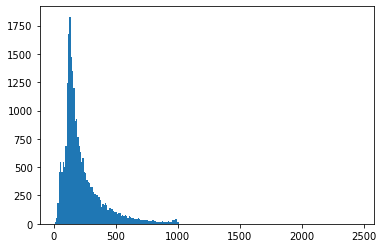

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [70]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [71]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [72]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [73]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [74]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1714112   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 22s 108ms/step - loss: 0.6283 - accuracy: 0.6547 - val_loss: 0.4953 - val_accuracy: 0.8326
Epoch 2/10
196/196 [==============================] - 20s 102ms/step - loss: 0.3314 - accuracy: 0.8827 - val_loss: 0.3008 - val_accuracy: 0.8745
Epoch 3/10
196/196 [==============================] - 20s 103ms/step - loss: 0.1820 - accuracy: 0.9348 - val_loss: 0.2939 - val_accuracy: 0.8782
Epoch 4/10
196/196 [==============================] - 22s 110ms/step - loss: 0.1016 - accuracy: 0.9698 - val_loss: 0.3202 - val_accuracy: 0.8739
Epoch 5/10
196/196 [==============================] - 21s 105ms/step - loss: 0.0493 - accuracy: 0.9893 - val_loss: 0.3551 - val_accuracy: 0.8704
Epoch 6/10
196/196 [==============================] - 20s 103ms/step - loss: 0.0230 - accuracy: 0.9970 - val_loss: 0.3926 - val_accuracy: 0.8692
Epoch 7/10
196/196 [==============================] - 20s 104ms/step - loss: 0.0123 - accuracy: 0.9989 - val_loss: 0.4287 - val_ac

**Задание** Подсчитайте качество модели на тесте

In [76]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 5s 7ms/step - loss: 0.4824 - accuracy: 0.8667


[0.4824173152446747, 0.8667200207710266]